In [5]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import librosa
import librosa.display
from IPython.display import Audio

In [6]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

dataset_files = os.listdir(path)

print("Files in the dataset directory:")
for file_name in dataset_files:
    print(file_name)

Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Files in the dataset directory:
TESS Toronto emotional speech set data
tess toronto emotional speech set data


In [9]:
data_subfolder = 'TESS Toronto emotional speech set data'
data_path = os.path.join(path, data_subfolder)

**Reasoning**:
The previous step successfully explored the directory structure. Now, I need to collect all audio file paths and extract their corresponding emotional labels to prepare the data for further analysis. A pandas DataFrame is an appropriate structure to store this information.



In [10]:
file_paths = []
emotions = []

for root, dirs, files in os.walk(data_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            file_path = os.path.join(root, file_name)
            file_paths.append(file_path)

            # Extract emotion from the folder name (e.g., 'YAF_fear' -> 'fear')
            emotion = os.path.basename(root).split('_')[-1].lower()
            # Handle 'pleasant_surprise' case if it exists as 'Pleasant_surprise'
            if emotion == 'surprise':
                if 'pleasant_surprise' in os.path.basename(root).lower():
                    emotion = 'pleasant_surprise'
            emotions.append(emotion)

# Create a DataFrame
df = pd.DataFrame({
    'File_Path': file_paths,
    'Emotion': emotions
})

print(f"Total audio files found: {len(df)}")
print("First 5 rows of the DataFrame:")
print(df.head())
print("\nEmotion distribution:")
print(df['Emotion'].value_counts())


Total audio files found: 2800
First 5 rows of the DataFrame:
                                           File_Path Emotion
0  /kaggle/input/toronto-emotional-speech-set-tes...    fear
1  /kaggle/input/toronto-emotional-speech-set-tes...    fear
2  /kaggle/input/toronto-emotional-speech-set-tes...    fear
3  /kaggle/input/toronto-emotional-speech-set-tes...    fear
4  /kaggle/input/toronto-emotional-speech-set-tes...    fear

Emotion distribution:
Emotion
fear                 400
angry                400
disgust              400
neutral              400
sad                  400
happy                400
pleasant_surprise    200
surprised            200
Name: count, dtype: int64


<Axes: xlabel='Emotion', ylabel='count'>

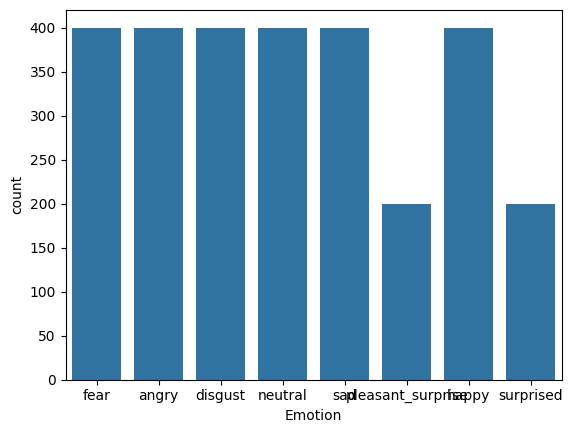

In [12]:
sns.countplot(data=df, x='Emotion')